In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
# from joblib import Parallel, delayed

olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
ncore = 48
if ncore > mp.cpu_count():
    ncore = mp.cpu_count()
ncore

48

# Workflow starts here!

In [4]:
###################### need to change start
ipts="25265"
###################### need to change end

## Find CT scan location

In [5]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['2022_12_16_samples546',
 '2022_11_08_tube1_sample1_2_3_from_bottom',
 '2022_12_15_samples123',
 '2022_12_16_samples123',
 '2022_11_09_tube2_sample5_4_6_from_bottom',
 '2022_12_15_samples546']

## Find OB location

In [6]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['2022_12_16', '2022_12_15', '2022_11_09', 'OBs_November11_2022']

## Find DC location

In [7]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2022_11_08_QHY', '2022_12_15_DC']

In [44]:
###################### need to change start
sample_name = "2022_12_15_samples546"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_12_15")
dc_dir = os.path.join(dc_loc, "2022_12_15_DC")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will *NOT* be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + sample_name + ".h5"
###################### need to change end

# Load all data files (CT, OB and DC)

In [9]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 529 of angle 179.86
Found index of 0 degree projections: 0 of angle 0.0
Loading 1059 CT projections...


1059it [01:47,  9.88it/s]


1059 CT projections loaded!
Shape: (1059, 2048, 2048)
Loading 5 Open Beam (OB) images...


5it [00:00, 15.12it/s]


5 Open Beam (OB) images loaded!
Shape: (5, 2048, 2048)
Loading 5 Dark Current (DC) images...


5it [00:00, 13.07it/s]

5 Dark Current (DC) images loaded!
Shape: (5, 2048, 2048)


# Visual verification of loaded files

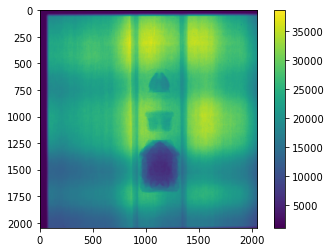

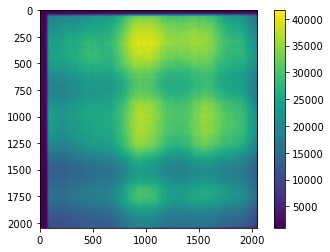

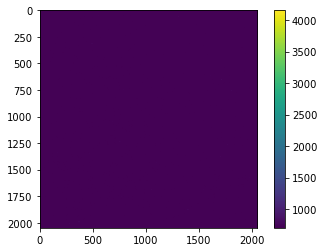

In [10]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


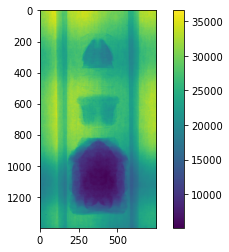

In [11]:
###################### need to change start
crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 750
crop_right = 1500
crop_top = 400
crop_bottom = 1800
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', True)
history_dict = rocku.log(history_dict, 'crop_roi', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)

Time: 16.185569449327886 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(1059, 1400, 750)


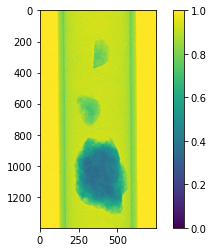

In [13]:
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


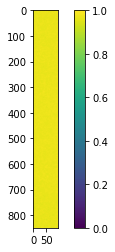

In [14]:
###################### need to change start
bg_left = 5
bg_right = 100
bg_top = 250
bg_bottom = 1100
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

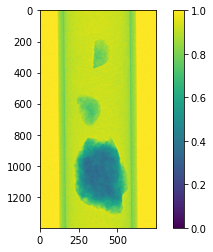

Time: 15.775602825917304 s


In [15]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
bg_roi_dict = {
    'left': bg_left,
    'right': bg_right,
    'top': bg_top,
    'bottom': bg_bottom
}
history_dict = rocku.log(history_dict, 'beam_fluc_corr', True)
history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi', bg_roi_dict)

# Minus log conversion

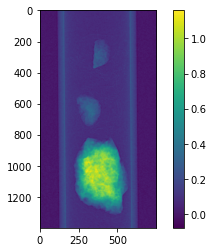

In [16]:
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'minus_log', True)

# Find and correct tilt

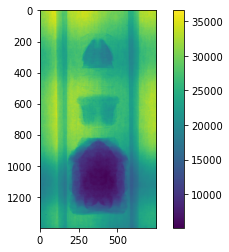

(1400, 750)

In [17]:
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
proj_crop_min.shape

Tilt correction ROI at 0 degree:


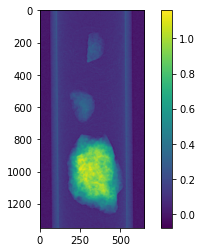

Tilt correction ROI at 180 degree:


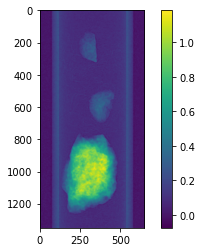

In [18]:
###################### need to change start
tt_left = 50
tt_right = 700
tt_top = 50
tt_bottom = 1800
###################### need to change start
tt_roi_dict = {
    'left': tt_left,
    'right': tt_right,
    'top': tt_top,
    'bottom': tt_bottom
}
tt_000deg_mlog = proj_mlog[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_mlog = proj_mlog[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_000deg_trans = proj_norm[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_trans = proj_norm[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
print("Tilt correction ROI at 0 degree:")
# plt.imshow(tt_000deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_000deg_mlog)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree:")
# plt.imshow(tt_180deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_180deg_mlog)
plt.colorbar()
plt.show()

In [19]:
print("Finding the tilt angle using transmission images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_trans, image180=tt_180deg_trans)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using transmission images...
Found the tilt angle:  0.20934442053224164


In [20]:
print("Finding the tilt angle using minus log images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_mlog, image180=tt_180deg_mlog)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using minus log images...
Found the tilt angle:  0.1949462403711455


In [21]:
t0 = timeit.default_timer()
proj_mlog_tilt = tilt.apply_tilt_correction(proj_mlog, tilt_ang.x, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'tilt_corr_roi', tt_roi_dict)
history_dict = rocku.log(history_dict, 'tilt_corr', tilt_ang.x)

/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/imars3d-0.1.3-py3.10.egg/imars3d/filters/tilt.py:115: TqdmWarning: Iterable length 1059 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.


Applying tilt corr:   0%|          | 0/1059 [00:00<?, ?it/s]

Time cost 0.6449389735547205 min


Projection at 0 degree:


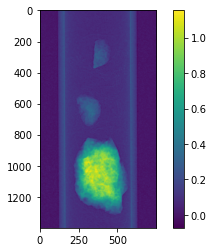

Projection at 180 degree (flipped):


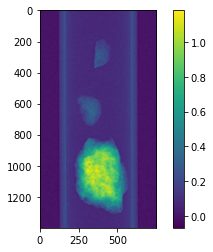

In [22]:
print("Projection at 0 degree:")
plt.imshow(proj_mlog_tilt[proj000_idx])# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog_tilt[proj180_idx]))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Ring Artifact Removal

Before ring removal:


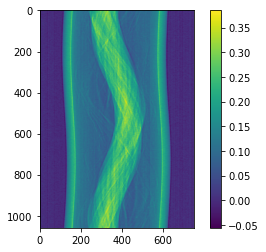

In [23]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (a) Vo's approach from tomopy

In [ ]:
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
t0 = timeit.default_timer()
proj_mlog_rmv_vo = tomopy.remove_all_stripe(proj_mlog_tilt, ncore=ncore, nchunk=nchunk)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'Vo')

In [ ]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (b) bm3d approach

In [ ]:
# t0 = timeit.default_timer()
# results = Parallel(n_jobs=16, prefer="threads")(delayed(ndi.gaussian_filter)(data[:, i, :], (3, 5), 0) for i in range(n_slice))
# t1 = timeit.default_timer()

In [ ]:
t0 = timeit.default_timer()
print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
proj_mlog_rmv_bm3d = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'bm3d')

Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.
Denoising sinogram 0
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 12
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 13
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 14
k: 4
k: 3


Before ring removal:


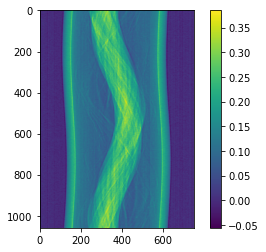

After ring removal:


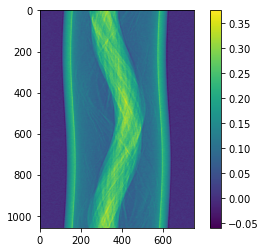

Difference:


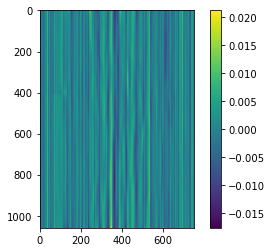

In [25]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [26]:
# proj_mlog_to_recon = proj_mlog_rmv_vo.astype(np.float32)
proj_mlog_to_recon = proj_mlog_rmv_bm3d.astype(np.float32)
sino_norm = np.moveaxis(proj_norm, 1, 0)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

In [27]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog_to_recon[proj000_idx,:,:]), np.squeeze(proj_mlog_to_recon[proj180_idx,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 372.0


In [28]:
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center = calc.find_center_360(sino_mlog_to_recon[int(sino_mlog_to_recon.shape[0]/2)], win_width=800)[0]
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 371.60650634765625


# Reconstruction

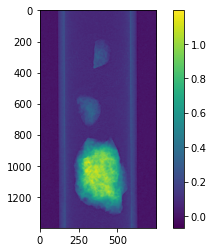

In [36]:
plt.imshow(proj_mlog_to_recon[1])
plt.colorbar()
plt.show()

371.60650634765625


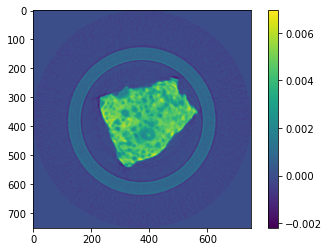

In [33]:
print(rot_center)
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[1100], rot_center, angles=ang_rad, apply_log=False)
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

In [38]:
proj_mlog_to_recon.shape

(1059, 1400, 750)

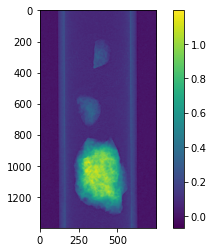

In [37]:
subset = False
# subset = True
if subset:
    _proj_mlog_to_recon = rocku.crop(proj_mlog_to_recon, 0, proj_mlog_to_recon.shape[2]-1, 600, 1200, subset)
else:
    _proj_mlog_to_recon = proj_mlog_to_recon[:]
plt.imshow(_proj_mlog_to_recon[1])
plt.colorbar()
plt.show()

In [39]:
t0 = timeit.default_timer()
recon_algo = 'gridrec'
########## tomopy
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
recon = tomopy.recon(_proj_mlog_to_recon, ang_rad, center=rot_center, algorithm=recon_algo, ncore=ncore, nchunk=nchunk)
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)

Chunk size:  23
Time cost 0.12960675732853513 min


In [40]:
pix_um = 42.7 #um
pix_cm = pix_um/10000
recon_cm = recon/pix_cm
history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)

# Export recon files

In [41]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name# + "_new"
dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)

# Export to HDF5

In [42]:
history_dict

{'crop': True,
 'crop_roi': {'left': 750, 'right': 1500, 'top': 400, 'bottom': 1800},
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 5, 'right': 100, 'top': 250, 'bottom': 1100},
 'minus_log': True,
 'tilt_corr_roi': {'left': 50, 'right': 700, 'top': 50, 'bottom': 1800},
 'tilt_corr': 0.1949462403711455,
 'ring_removal': 'bm3d',
 'rot_center': 371.60650634765625,
 'recon_algo': 'gridrec',
 'pixel_size_um': 42.7}

In [45]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=('cm-1',))
    f.create_dataset('tomo/recon/recon_volume', data=recon_cm)

In [46]:
losa.get_hdf_tree(output_hdf5)

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (1059,)
    │   ├── ang_rad (1059,)
    │   ├── fname (1059,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── dc_fake (1400, 750)
    │   ├── ob_fake (1400, 750)
    │   ├── proj_mlog_to_recon (1059, 1400, 750)
    │   └── proj_norm (1059, 1400, 750)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── fluc_corr_roi_min (850, 95)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (1400, 750)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (1400, 750, 750)
    └── sino
        │
        ├── sino_mlog_to_recon (1400, 1059, 750)
        └── sino_norm (1400, 1059, 750)


deque([' tomo',
       '    │',
       '    ├── info',
       '    │   │',
       '    │   ├── ang_deg (1059,)',
       '    │   ├── ang_rad (1059,)',
       '    │   ├── fname (1059,)',
       '    │   ├── proj000_idx (1,)',
       '    │   └── proj180_idx (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── dc_fake (1400, 750)',
       '    │   ├── ob_fake (1400, 750)',
       '    │   ├── proj_mlog_to_recon (1059, 1400, 750)',
       '    │   └── proj_norm (1059, 1400, 750)',
       '    ├── raw_ref',
       '    │   │',
       '    │   ├── dc_max (2048, 2048)',
       '    │   ├── fluc_corr_roi_min (850, 95)',
       '    │   ├── ob_min (2048, 2048)',
       '    │   ├── proj_crop_roi_min (1400, 750)',
       '    │   └── proj_min (2048, 2048)',
       '    ├── recon',
       '    │   │',
       '    │   ├── history (1,)',
       '    │   ├── recon_unit (1,)',
       '    │   └── recon_volume (1400, 750, 750)',
       '    └── sino',
       '        │',
       '   